# Пакетная нормализация

In [1]:
import numpy as np, numpy.random as nr
import pandas as pd
import matplotlib.pyplot as plt

import os
import struct
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

_ = torch.manual_seed(1)

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

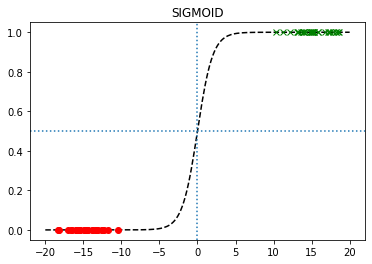

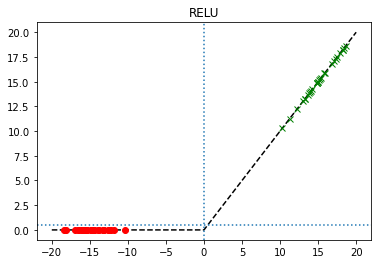

In [3]:
# Сдвинутые данные на входе в функции активации.
data_size = 30
random_left = 2 * nr.randn(data_size) - 15
random_right = 2 * nr.randn(data_size) + 15
wing = 20
x_sigmoid = np.linspace(-wing, wing, wing * 10 + 1)


for activation in (sigmoid, relu):
    plt.title(activation.__name__.upper())
    plt.plot(x_sigmoid, activation(x_sigmoid), '--k')
    plt.plot(random_left, activation(random_left), 'or')
    plt.plot(random_right, activation(random_right), 'gx')
    plt.axvline(0,   linestyle=':')
    _ = plt.axhline(0.5, linestyle=':')
    plt.show()

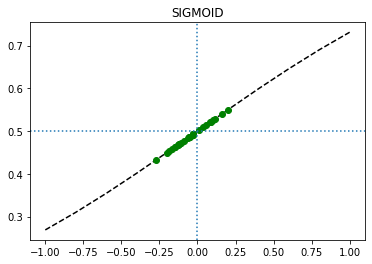

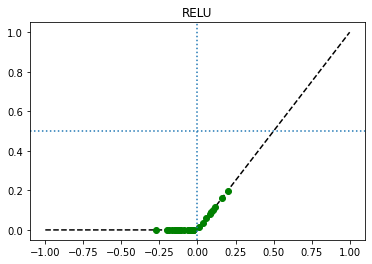

In [4]:
# Теперь что происходит при нулевом мат. ожидании и слишком малой дисперсии
data_size = 30
scale = 0.1
random_center = scale * nr.randn(data_size) - scale/2
wing = 1
x_sigmoid = np.linspace(-wing, wing, wing * 10 + 1)


for activation in (sigmoid, relu):
    plt.title(activation.__name__.upper())
    plt.plot(x_sigmoid, activation(x_sigmoid), '--k')
    plt.plot(random_center, activation(random_center), 'og')
    plt.axvline(0,   linestyle=':')
    _ = plt.axhline(0.5, linestyle=':')
    plt.show()
# Потеря нелинейности для сигмоиды

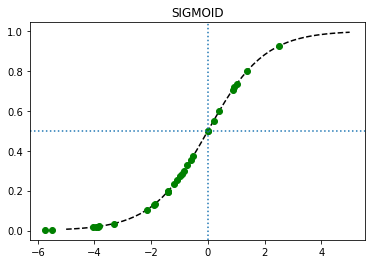

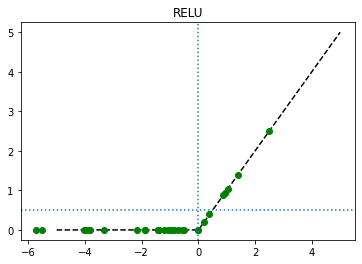

In [5]:
# Теперь что происходит при нулевом мат. ожидании и единичной дисперсии
data_size = 30
random_center = 2 * nr.randn(data_size) - 1
wing = 5
x_sigmoid = np.linspace(-wing, wing, wing * 10 + 1)


for activation in (sigmoid, relu):
    plt.title(activation.__name__.upper())
    plt.plot(x_sigmoid, activation(x_sigmoid), '--k')
    plt.plot(random_center, activation(random_center), 'og')
    plt.axvline(0,   linestyle=':')
    _ = plt.axhline(0.5, linestyle=':')
    plt.show()

***Ковариационный сдвиг*** — это ситуация, когда распределения значений признаков в обучающей и тестовой выборке имеют разные параметры (математическое ожидание, дисперсия и т.д.).

Нейронная сеть меняет свои веса с каждым пройденным мини-пакетом, и так как выходы текущего слоя являются входными признаками для следующего, то каждый слой в сети попадает в ситуацию, когда распределение входных признаков меняется каждый шаг, т.е. каждый пройденный мини-батч, что приводит к **внутреннему ковариационному сдвигу**

<img src="media/batchnorm1.png" alt="BatchNorm" style="width: 600px;"/>

### Распространённые виды нормализации
<img src="media/normalization_types.png" alt="Norms" style="width: 600px;"/>

### Пакетная нормализация

Базовая идея **пакетной нормализации** (batch normalization) - ограничить внутренний ковариационный сдвиг путём нормализации выхода каждого слоя, преобразуя их в распределения с нулевым математическим ожиданием и единичной дисперсией.

Так формулировали идею авторы в своей [статье 2015 года](https://arxiv.org/pdf/1502.03167.pdf): "Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring **lower learning rates** and **careful parameter initialization**, and makes it notoriously hard to train models with saturating nonlinearities".



На практике пакетная нормализация <span style="color:red">иногда</span> приводит быстрой сходимости, меньшей чувствительности к выбору скорости обучения и лучшему качеству на тестовой выборке. Для подтверждения полезности требуются эксперименты в каждом конкретном случае.

#### Алгоритм пакетной нормализации
В общем виде алгоритм выглядит следующим образом:

<img src="media/bn_algo.png" alt="BatchNormAlgo" style="width: 400px;"/>

Рассмотрим пакетную нормализацию тензоров в свёрточной сети.

Тензор данных имеет размерность $(N, C, H, W)$, где

$N$ - размер пакета,

$C$ - количество карт (каналов),

$H$ - высота карты, 

$W$ - ширина карты.

Индексы:

$t$ - номер элемента пакета,

$c$ - номер карты,

$m$ - номер элемента карты признаков по высоте,

$n$ - номер элемента карты признаков по ширине.


Теперь для каждой взятой карты признаков $c$ можем посчитать математическое ожидание и дисперсию.

$\mu_c = \frac{1}{NHW} \sum_{t=1}^{N} \sum_{m=1}^{H} \sum_{m=1}^{W}x_{tcmn} $ 

$\sigma_c^2 = \frac{1}{NHW} \sum_{t=1}^{N} \sum_{m=1}^{H} \sum_{m=1}^{W}(x_{tcmn} - \mu_c)^2  $

$\hat{x}_{tcmn} = \frac{x_{tcmn}-\mu_c}{\sqrt{\sigma_i^2 + \epsilon}}$

$y_{tcmn} = \lambda\hat{x}_{tcmn} + \beta$

<span style="color:green">Возможно ли прийти к выходному сигналу пакетной нормализации равному входному не меняя алгоритма?</span>


**Примечание:** математическое ожидание и дисперсия считаются заново для каждого мини-пакета заново во время обучения, но среднее значение этих величин берётся *по всему пакету* в тестовом режиме.

### Прямой проход пакетной нормализации

In [6]:
import os
import struct
import numpy as np
import torch
from torch.nn import Module
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

_ = torch.manual_seed(1)

In [7]:
def debug_tensor(tensor, debug, prefix: str):
    if debug:
        print(f'{prefix}:\n{tensor.numpy()}\nShape: {tensor.shape}\n')

def batchnorm_forward(x, gamma, beta, eps=1e-20, debug=True):
    N, C, H, W = x.shape
    num_elements = N * H * W
    print(f'Number of elements in 1 channel: {num_elements}')
    print(N, C, H, W)
    
    # Считаем математическое ожидание каждого канала по всему мини-пакету
    mu = (torch.sum(x, axis = (2,3)) / num_elements).unsqueeze(-1).unsqueeze(-1)
    debug_tensor(mu, debug, 'mu')
    
    # Отнимаем среднее от всех входных значений (переиспользуемое значение)
    xmu = x - mu.expand_as(x)
    debug_tensor(xmu, debug, 'xmu')
    
    # Считаем дисперсию 
    squared_xmu = xmu.pow(2)
    debug_tensor(squared_xmu, debug, 'squared_xmu')
    
    squared_xmu_sum = squared_xmu.sum(axis=(2,3)).unsqueeze(-1).unsqueeze(-1)
    debug_tensor(squared_xmu_sum, debug, 'squared_xmu_sum')
    
    var = squared_xmu_sum / num_elements
    debug_tensor(var, debug, 'var')
    
    # Нормализуем
    denom = torch.sqrt(var + eps)
    debug_tensor(denom, debug, 'denom')  
    
    xhat = torch.div(xmu, denom.expand_as(xmu))
    debug_tensor(xhat, debug, 'xhat')
    
    # Применяем масштабирование и сдвиг
    out = gamma * xhat + beta
    debug_tensor(out, debug, 'out')
    
    return out

In [40]:
# Протестируем нормализацию
# Нулевое мат. ожидание и единичная дисперсия
image = [[[10, 20, 30],
         [40, 40, 100]], # первый канал
        [[5, 6, 7],
         [40, 40, 3]]] # второй канал

# image = [[[2, 4, 6],
#          [2, 4, 6]]] # первый канал

data = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
print(f'Data: \n {data.numpy()} \nShape: {data.shape}\n')

normalized = batchnorm_forward(data, 1.0, 0.0)
mean = normalized.mean(axis=(2,3)).numpy()
var = normalized.var(axis=(2,3), unbiased=False).numpy()  # без поправки Бесселя


# Сравниваем с gfrtnyjq нормализацией в Torch
bn_torch = nn.BatchNorm2d(1, eps=1e-20, momentum=None, affine=True)
normalized_torch = bn_torch(data)
print(f'Normalized by Torch\n: {normalized_torch.detach().numpy()}')

print(f'Normalized mean and variance are [{mean} {var}]')

Data: 
 [[[[ 10.  20.  30.]
   [ 40.  40. 100.]]

  [[  5.   6.   7.]
   [ 40.  40.   3.]]]] 
Shape: torch.Size([1, 2, 2, 3])

Number of elements in 1 channel: 6
1 2 2 3
mu:
[[[[40.      ]]

  [[16.833334]]]]
Shape: torch.Size([1, 2, 1, 1])

xmu:
[[[[-30.       -20.       -10.      ]
   [  0.         0.        60.      ]]

  [[-11.833334 -10.833334  -9.833334]
   [ 23.166666  23.166666 -13.833334]]]]
Shape: torch.Size([1, 2, 2, 3])

squared_xmu:
[[[[ 900.       400.       100.     ]
   [   0.         0.      3600.     ]]

  [[ 140.02779  117.36112   96.69446]
   [ 536.6944   536.6944   191.36113]]]]
Shape: torch.Size([1, 2, 2, 3])

squared_xmu_sum:
[[[[5000.    ]]

  [[1618.8333]]]]
Shape: torch.Size([1, 2, 1, 1])

var:
[[[[833.3333 ]]

  [[269.80554]]]]
Shape: torch.Size([1, 2, 1, 1])

denom:
[[[[28.867514]]

  [[16.425758]]]]
Shape: torch.Size([1, 2, 1, 1])

xhat:
[[[[-1.0392305  -0.6928203  -0.34641016]
   [ 0.          0.          2.078461  ]]

  [[-0.72041327 -0.65953326 -0.598653

RuntimeError: running_mean should contain 2 elements not 1

In [38]:
# Масштабирование
normalized = batchnorm_forward(data, 2.0, 0.0)
mean = normalized.mean(axis=(2,3)).numpy()
var = normalized.var(axis=(2,3), unbiased=False).numpy()
print(f'Normalized mean and variance are [{mean} {var}]')

Number of elements in 1 channel: 6
1 1 2 3
mu:
[[[[4.]]]]
Shape: torch.Size([1, 1, 1, 1])

xmu:
[[[[-2.  0.  2.]
   [-2.  0.  2.]]]]
Shape: torch.Size([1, 1, 2, 3])

squared_xmu:
[[[[4. 0. 4.]
   [4. 0. 4.]]]]
Shape: torch.Size([1, 1, 2, 3])

squared_xmu_sum:
[[[[16.]]]]
Shape: torch.Size([1, 1, 1, 1])

var:
[[[[2.6666667]]]]
Shape: torch.Size([1, 1, 1, 1])

denom:
[[[[1.6329932]]]]
Shape: torch.Size([1, 1, 1, 1])

xhat:
[[[[-1.2247448  0.         1.2247448]
   [-1.2247448  0.         1.2247448]]]]
Shape: torch.Size([1, 1, 2, 3])

out:
[[[[-2.4494896  0.         2.4494896]
   [-2.4494896  0.         2.4494896]]]]
Shape: torch.Size([1, 1, 2, 3])

Normalized mean and variance are [[[0.]] [[3.9999995]]]


In [39]:
# Восстановление входного сигнала
var = data.var(axis=(2,3), unbiased=False)
gamma = torch.sqrt(var).unsqueeze(-1).unsqueeze(-1) 
beta = data.mean(axis=(2,3)).unsqueeze(-1).unsqueeze(-1)  

print(var.numpy(), '|\n\n', gamma.numpy(), '|\n\n' , beta.numpy())

normalized = batchnorm_forward(data, gamma, beta)
mean = normalized.mean(axis=(2,3)).numpy()
var = normalized.var(axis=(2,3), unbiased=False).numpy()
print(f'Normalized mean and variance are [{mean} {var}]')

[[2.6666667]] |

 [[[[1.6329932]]]] |

 [[[[4.]]]]
Number of elements in 1 channel: 6
1 1 2 3
mu:
[[[[4.]]]]
Shape: torch.Size([1, 1, 1, 1])

xmu:
[[[[-2.  0.  2.]
   [-2.  0.  2.]]]]
Shape: torch.Size([1, 1, 2, 3])

squared_xmu:
[[[[4. 0. 4.]
   [4. 0. 4.]]]]
Shape: torch.Size([1, 1, 2, 3])

squared_xmu_sum:
[[[[16.]]]]
Shape: torch.Size([1, 1, 1, 1])

var:
[[[[2.6666667]]]]
Shape: torch.Size([1, 1, 1, 1])

denom:
[[[[1.6329932]]]]
Shape: torch.Size([1, 1, 1, 1])

xhat:
[[[[-1.2247448  0.         1.2247448]
   [-1.2247448  0.         1.2247448]]]]
Shape: torch.Size([1, 1, 2, 3])

out:
[[[[2. 4. 6.]
   [2. 4. 6.]]]]
Shape: torch.Size([1, 1, 2, 3])

Normalized mean and variance are [[[4.]] [[2.6666667]]]


### Обучение сети с пакетной нормализацией

In [11]:
class Model(Module):
    def __init__(self, use_bn=False):
        super(Model, self).__init__()
        self.use_bn = use_bn
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.a1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.a2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 4 * 4, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.a3 = nn.ReLU()
        
        self.fc2 = nn.Linear(32, 10)
        

    def forward(self, x):
        y = self.conv1(x)
        if self.use_bn:
            y = self.bn1(y)
        y = self.a1(y)
        y = self.conv2(y)
        if self.use_bn:
            y = self.bn2(y)
        y = self.a2(y)
        y = self.pool1(y)
        y = self.flatten(y)
        y = self.fc1(y)
        if self.use_bn:
            y = self.bn3(y)
        y = self.a3(y)
        y = self.fc2(y)
        return y

In [12]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        
def get_losshist_column(use_bn, optimizer, learning_rate):
    bn_status = 'bn' if use_bn else 'no_bn'
    return f'{bn_status}_{optimizer}_lr{learning_rate}'

def log_loss(epoch, use_bn, optimizer, learning_rate, loss_history, loss):
    column = get_losshist_column(use_bn, optimizer, learning_rate)
    loss_history.loc[epoch, column] = loss
    

def get_optimizer(optim_name):
    optims = {
        'adam': Adam,
        'sgd': SGD
    }
    return optims[optim_name.lower()]

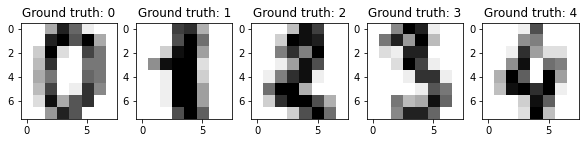

In [13]:
# Загружаем выборку digits
digits = load_digits(n_class=10, return_X_y=False, as_frame=False)

# Проверяем, что данные загружены верно
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Ground truth: %i' % label)

In [14]:
# Разбиваем выборку на обучающую и валидационную
x_train, x_val, y_train, y_val = train_test_split(digits.images,
                                                  digits.target,
                                                  test_size=0.2,
                                                  shuffle=False)
print(f'All files: {len(digits.images)}\nTrain set: {len(x_train)}\nValidation set: {len(x_val)}')

All files: 1797
Train set: 1437
Validation set: 360


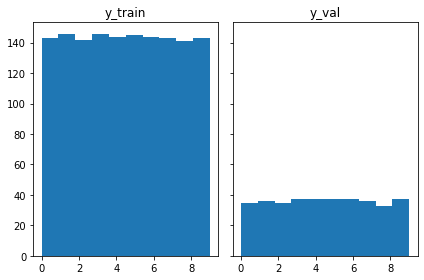

In [15]:
# Проверяем распределение по классам
n_bins = 10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].set_title('y_train')
axs[0].hist(y_train, bins=n_bins)
axs[1].set_title('y_val')
axs[1].hist(y_val, bins=n_bins)
plt.show()

In [16]:
# Нормализуем изображения
train_mean = np.mean(x_train)
train_std = np.std(x_train)

val_mean = np.mean(x_val)
val_std = np.std(x_val)

x_train_norm = (x_train - train_mean) / train_std
x_val_norm = (x_val - val_mean) / val_std

print(f'Train mean={x_train_norm.mean():.2f} variance={x_train_norm.var():.2f}')
print(f'Validation mean={x_val_norm.mean():.2f} variance={x_val_norm.var():.2f}')

Train mean=-0.00 variance=1.00
Validation mean=0.00 variance=1.00


In [17]:
# Преобразуем данные в тензоры
train_label = torch.tensor(y_train, dtype=torch.long)
train_x = torch.tensor(x_train_norm, dtype=torch.float32).unsqueeze(1)
val_label = torch.tensor(y_val, dtype=torch.long)
val_x = torch.tensor(x_val_norm, dtype=torch.float32).unsqueeze(1)

In [18]:
def train_model(epochs, use_bn, optimizer_name, learning_rate, loss_history, log_dir, model_file=None):
    if model_file:
        model = torch.load(model_file)
    else:
        model = Model(use_bn)
        model.apply(init_weights)
    
    optimizer = get_optimizer(optimizer_name)(model.parameters(), lr=learning_rate)
    
    cross_error = CrossEntropyLoss()
    t = trange(epochs)
    
    for e in t:
        t.set_description(f'Epoch {e+1}, {get_losshist_column(use_bn, optimizer_name, learning_rate)}')
        model.train()
        optimizer.zero_grad()
        predict_y = model(train_x) # для обучения используем весь пакет
        loss = cross_error(predict_y, train_label)
        loss_np = loss.detach().numpy()
        log_loss(e, use_bn, optimizer_name, learning_rate, loss_history, loss_np)
               
        loss.backward()
        optimizer.step()
        
        correct = 0
        _sum = 0
        model.eval()
        predict_y = model(val_x)
        predict_ys = torch.argmax(predict_y, axis=-1)
        matches = predict_ys == val_label
        correct += torch.sum(matches, axis=-1)
        _sum += matches.shape[0]
        accuracy = correct.numpy() / _sum
        t.set_postfix(loss=loss_np, accuracy=accuracy)
    
    bn_status = 'bn' if use_bn else 'no_bn'
    torch.save(model,
               os.path.join(log_dir, f'{bn_status}_{optimizer_name}_{learning_rate:.6f}.pth'))

In [19]:
use_bn = [True, False]
optimizers = ['SGD']
learning_rates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10]

train_chedule = []
for bn in use_bn:
    for opt in optimizers:
        for lr in learning_rates:
            train_chedule.append({
                'use_bn': bn,
                'optimizer': opt,
                'learning_rate': lr
            })

epochs = 300
loss_history = pd.DataFrame(index=range(epochs), dtype=float)
log_dir = 'batchnorm_log'
os.makedirs(log_dir, exist_ok=True)
for params in train_chedule:
    train_model(epochs,
                params['use_bn'],
                params['optimizer'],
                params['learning_rate'],
                loss_history,
                log_dir)


pd.options.display.float_format = '{:.4f}'.format
print(f'Final loss: {loss_history.iloc[-1]}')
loss_history.to_pickle(os.path.join(log_dir, 'loss_history.pkl'))

Epoch 300, no_bn_SGD_lr10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.51it/s, accuracy=0.103, loss=2.3025212]

Final loss: bn_SGD_lr0.001      1.5509
bn_SGD_lr0.003      1.0116
bn_SGD_lr0.01       0.4304
bn_SGD_lr0.03       0.1390
bn_SGD_lr0.1        0.0262
bn_SGD_lr0.3        0.0062
bn_SGD_lr1          0.0014
bn_SGD_lr3          0.0005
bn_SGD_lr10         2.3025
no_bn_SGD_lr0.001   1.8162
no_bn_SGD_lr0.003   0.9539
no_bn_SGD_lr0.01    0.2122
no_bn_SGD_lr0.03    0.0431
no_bn_SGD_lr0.1     0.0105
no_bn_SGD_lr0.3     0.0029
no_bn_SGD_lr1       2.3025
no_bn_SGD_lr3          NaN
no_bn_SGD_lr10      2.3025
Name: 299, dtype: float64


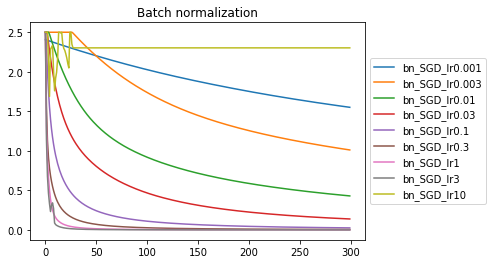

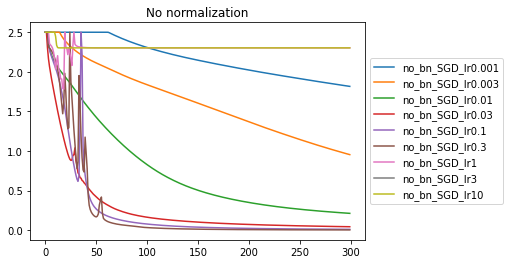

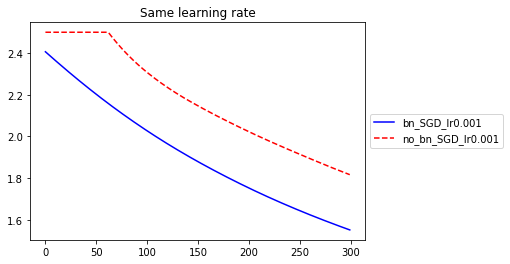

Batchnorm loss: 1.5508556365966797
Vanilla loss: 1.8161548376083374


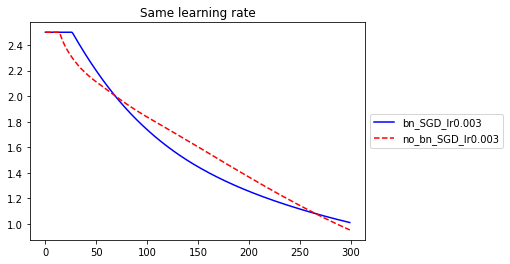

Batchnorm loss: 1.0116021633148193
Vanilla loss: 0.9539138078689575


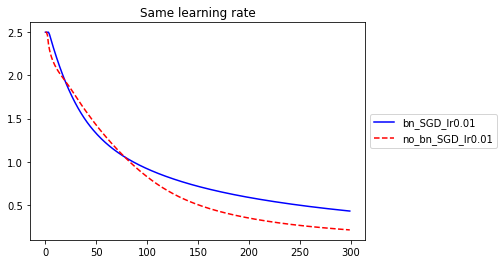

Batchnorm loss: 0.43044063448905945
Vanilla loss: 0.21215718984603882


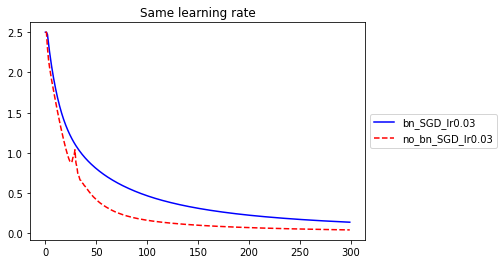

Batchnorm loss: 0.13895264267921448
Vanilla loss: 0.04308199882507324


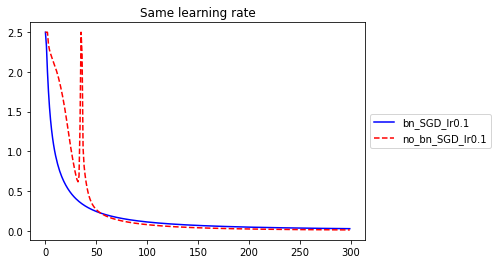

Batchnorm loss: 0.026175327599048615
Vanilla loss: 0.010457382537424564


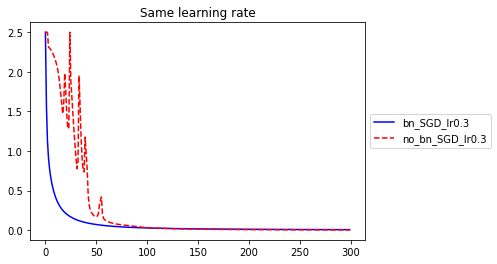

Batchnorm loss: 0.006234576925635338
Vanilla loss: 0.0028528941329568624


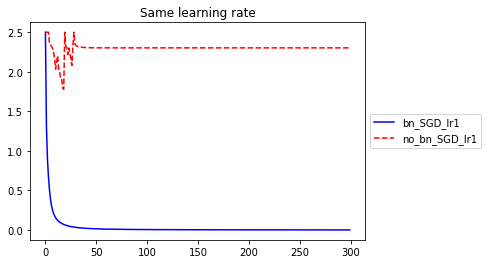

Batchnorm loss: 0.0013541963417083025
Vanilla loss: 2.3025143146514893


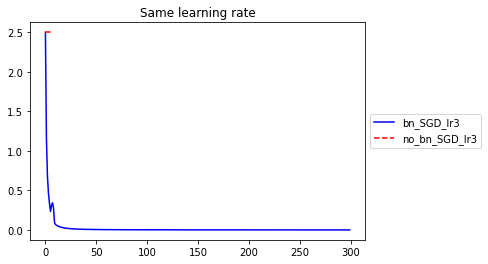

Batchnorm loss: 0.0004830184916500002
Vanilla loss: nan


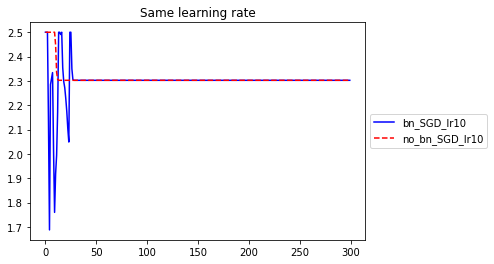

Batchnorm loss: 2.302521228790283
Vanilla loss: 2.302521228790283


In [37]:
# Отрисуем ход обучения отдельно ReLU, отдельно Sigmoid
loss_history.head()
loss_history = pd.read_pickle(os.path.join(log_dir, 'loss_history.pkl'))
history_clipped = loss_history.clip(upper=2.5)  # умещаем всё в один масштаб
plot_step = int(len(train_chedule)/2)
bn = history_clipped.iloc[:,0:plot_step]
no_bn = history_clipped.iloc[:,plot_step:2*plot_step]

f = plt.figure()
plt.title('Batch normalization', color='black')
bn.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('No normalization', color='black')
no_bn.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Сравнение одинаковых скоростей обучения
for i in range(plot_step):
    f = plt.figure()
    plt.title('Same learning rate', color='black')
    history_clipped.iloc[:,i].plot(linestyle='solid', color='blue', ax=f.gca())
    history_clipped.iloc[:,i+plot_step].plot(linestyle='--', color='red', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()
    print(f'Batchnorm loss: {loss_history.iloc[-1, i]}\nVanilla loss: {loss_history.iloc[-1, i+plot_step]}')